# Imports

In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import glob

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import tqdm
from PIL import Image

train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

**Sections of this kernel**
- EDA
- Preprocessing
- 1st iteration


# EDA


## Main goal

The main task is to detect metastases in digital histopathology images of a 96 x 96px size. The images are taken from glass slide microscopes of stained lymph nodes. The major challenge is the presence of tiny metastases that can be as small as single cells and hard to identify. The images use Hematoxylin and Eosin (H&E) staining, resulting in various shades of pink, blue, and violet. Hematoxylin stains nucleic acids blue, whereas Eosin paints proteins in pink shades. The lymph nodes that are small glands filtering the fluid in the lymphatic system are often where breast cancer first spreads. Evaluation of lymph node metastases is part of the TNM classification process, a globally accepted system for understanding the extent of the spread of cancer. This process can be time-consuming and laborious for pathologists due to the large area of tissue they must examine, often resulting in smaller metastases being overlooked.

## Data loading


In [2]:
data = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
train = "/kaggle/input/histopathologic-cancer-detection/train"
test = "/kaggle/input/histopathologic-cancer-detection/test"
data["label"].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

It means that the dataset is imbalanced

In [3]:
def map_labels(label):
    if label == 0:
        return "non-cancer"
    elif label == 1:
        return "cancer"


# apply the function to the dataframe
data["human-readable"] = data["label"].apply(map_labels)

In [4]:
import cv2


def load_image(path):
    rgb_repr = cv2.imread(path)
    r, g, b = cv2.split(rgb_repr)[::-1]
    rgb_img = cv2.merge([r, g, b])  # useful for visibility
    return rgb_img

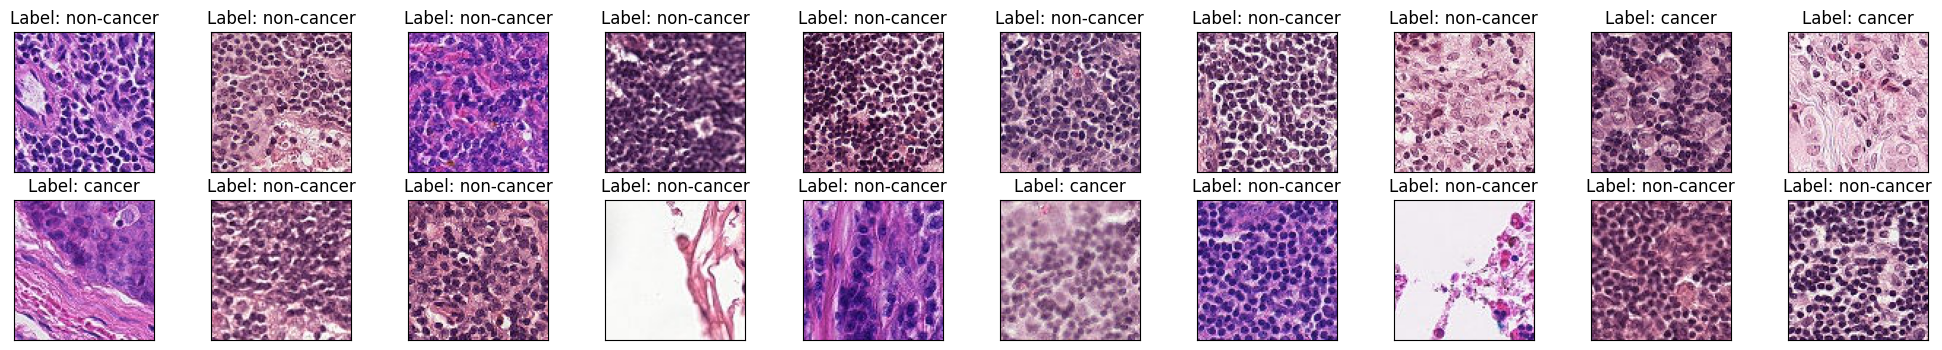

In [5]:
def visualize_random_images(path, labels, num_images=20, figsize=(25, 4)):
    fig = plt.figure(figsize=figsize)
    train_imgs = glob.glob(path + "/*")

    for idx, img in enumerate(np.random.choice(train_imgs, num_images)):
        ax = fig.add_subplot(2, num_images // 2, idx + 1, xticks=[], yticks=[])
        im = load_image(img)
        plt.imshow(im)
        lab = labels.loc[
            labels["id"] == os.path.basename(img).split(".")[0], "human-readable"
        ].values[0]
        ax.set_title(f"Label: {lab}")

    plt.show()


visualize_random_images("/kaggle/input/histopathologic-cancer-detection/train", data)

## Preprocessing

In [6]:
from enum import Enum

DEFAULT_LABEL = 0

class DataType(Enum):
    TRAIN = "train"
    TEST = "test"
    VALIDATION = "validation"     # optional 

class CustomDataset(Dataset):
    def __init__(
        self,
        data_pattern,
        datatype=DataType.TRAIN,
        transform=[],
        labels_dict={},
    ):
        self.datatype = datatype
        self.files = glob.glob(data_pattern)
        self.transformations_list = transform
        self.labels_dict = labels_dict
        if self.datatype == DataType.TRAIN:
            self.labels = [labels_dict[i.split(".")[0]] for i in self.image_files_list]
        else:
            self.labels = [DEFAULT_LABEL for _ in range(len(self.image_files_list))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = load_image( self.files[idx])
        image = self.transform(image=img)["image"]
        if self.datatype == DataType.TRAIN:
            label = self.labels_dict[img_name_short]
        else:
            label = 0
        return image, label


In [7]:
import torchvision.transforms as transforms

import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import cv2

In [8]:
img_class_dict = {k: v for k, v in zip(data.id, data.label)}
tr, val = train_test_split(data.label, stratify=data.label, test_size=0.1)

In [9]:
data_transforms = albumentations.Compose(
    [
        albumentations.Resize(224, 224),
        albumentations.HorizontalFlip(),
        albumentations.RandomBrightnessContrast(),
        albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
        albumentations.HueSaturationValue(),
        albumentations.Normalize(),
        ToTensorV2(),
    ]
)
data_transforms_test = albumentations.Compose(
    [albumentations.Resize(224, 224), albumentations.Normalize(), ToTensorV2()]
)

dataset = CustomDataset(
    datafolder=train,
    datatype="train",
    transform=data_transforms,
    labels_dict=img_class_dict,
)
test_set = CustomDataset(
    datafolder=test, datatype="test", transform=data_transforms_test
)
train_sampler = SubsetRandomSampler(list(tr.index))
valid_sampler = SubsetRandomSampler(list(val.index))
batch_size = 1024
num_workers = 0
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers
)

In [ ]:
def plot_samples(data, label, n_samples, axs, label_name):
    for i, idx in enumerate(data[data["label"] == label]["id"][:n_samples]):
        path = os.path.join(train, idx)
        axs[i].imshow(readCroppedImage(path + ".tif"))
    axs[0].set_ylabel(label_name, size="large")


fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Processed images", fontsize=20)

plot_samples(data, 0, 5, ax[0, :], "Negative samples")
plot_samples(data, 1, 5, ax[1, :], "Tumor tissue samples")

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for i, param in model_conv.named_parameters():
    param.requires_grad = False

In [ ]:
criterion = nn.BCELoss()

In [ ]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(2048, 2)

In [ ]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.99)
# scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
valid_loss_min = np.Inf
patience = 5
# current number of epochs, where validation loss didn't increase
p = 0
# whether training should be stopped
stop = False

# number of epochs to train the model
n_epochs = 1
for epoch in range(1, n_epochs + 1):
    print(time.ctime(), "Epoch:", epoch)

    train_loss = []
    # scheduler.step(epoch)
    train_auc = []

    for batch_i, (data, target) in tqdm.tqdm(enumerate(train_loader)):

        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output[:, 1], target.float())
        train_loss.append(loss.item())

        a = target.data.cpu().numpy()
        b = output[:, -1].detach().cpu().numpy()
        # train_auc.append(roc_auc_score(a, b))

        loss.backward()
        optimizer.step()

    model_conv.eval()
    val_loss = []
    val_auc = []
    for batch_i, (data, target) in enumerate(valid_loader):
        data, target = data.cuda(), target.cuda()
        output = model_conv(data)

        loss = criterion(output[:, 1], target.float())

        val_loss.append(loss.item())
        a = target.data.cpu().numpy()
        b = output[:, -1].detach().cpu().numpy()
        # val_auc.append(roc_auc_score(a, b))

    # print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid auc: {np.mean(val_auc):.4f}')
    print(
        f"Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}."
    )

    valid_loss = np.mean(val_loss)
    scheduler.step(valid_loss)
    if valid_loss <= valid_loss_min:
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                valid_loss_min, valid_loss
            )
        )
        torch.save(model_conv.state_dict(), "model.pt")
        valid_loss_min = valid_loss
        p = 0

    # check if validation loss didn't improve
    if valid_loss > valid_loss_min:
        p += 1
        print(f"{p} epochs of increasing val loss")
        if p > patience:
            print("Stopping training")
            stop = True
            break

    if stop:
        break

In [ ]:
valid_loss

In [ ]:
model_conv.eval()
preds = []
for batch_i, (data, target) in tqdm.tqdm(enumerate(test_loader)):
    data, target = data.cuda(), target.cuda()
    output = model_conv(data)

    pr = output[:, 1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [ ]:
test_preds = pd.DataFrame({"imgs": test_set.image_files_list, "preds": preds})
test_preds["imgs"] = test_preds["imgs"].apply(lambda x: x.split(".")[0])

In [ ]:
sub = pd.read_csv(
    "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"
)
sub = pd.merge(sub, test_preds, left_on="id", right_on="imgs")
sub = sub[["id", "preds"]]
sub.columns = ["id", "label"]
sub.head()

In [ ]:
sub.to_csv("sub.csv", index=False)